In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import copy
import random
from tqdm import tqdm
import seaborn as sns
random.seed(42)
np.random.seed(42)

# Exercise 4.2

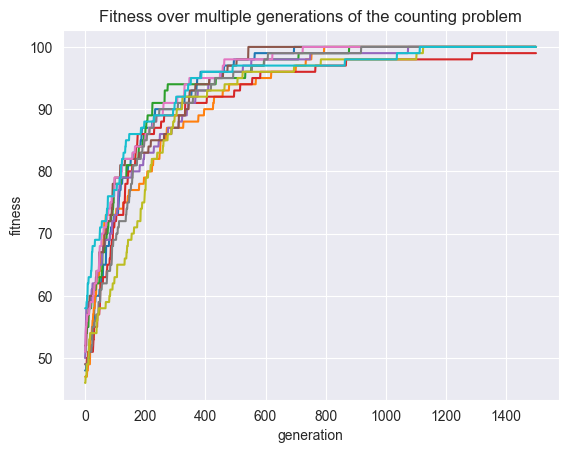

In [2]:
length=100
generations = 1500

def CountingProblem(length=100,generations=1500, always_replace=False):
    bitstring = ''.join(choice('01') for _ in range(length))
    mutation_rate = 1/length
    x_count = 0
    count_array = []

    for j in bitstring:
        if j == "1":
            x_count+=1

    for iter in range(generations):
        xm = copy.deepcopy(bitstring)
        for i in range(len(bitstring)):
            if random.random() < mutation_rate:
                if xm[i] == "0":
                    xm = xm[:i] + "1"+ xm[i + 1:]
                elif xm[i] == "1":
                    xm = xm[:i] + "0"+ xm[i + 1:]
        xm_count = 0
        for j in xm:
            if j == "1":
                xm_count+=1
        if xm_count > x_count and not always_replace:
            bitstring = copy.deepcopy(xm)
            x_count = xm_count
        elif always_replace:
            bitstring = copy.deepcopy(xm)
            x_count = xm_count
        count_array.append(x_count)

    return count_array

for i in range(10):
    count_array = CountingProblem()
    g = np.arange(0., 1500.)
    plt.plot(g, count_array)
    plt.xlabel('generation')
    plt.ylabel('fitness')
    plt.title('Fitness over multiple generations of the counting problem')
plt.show()


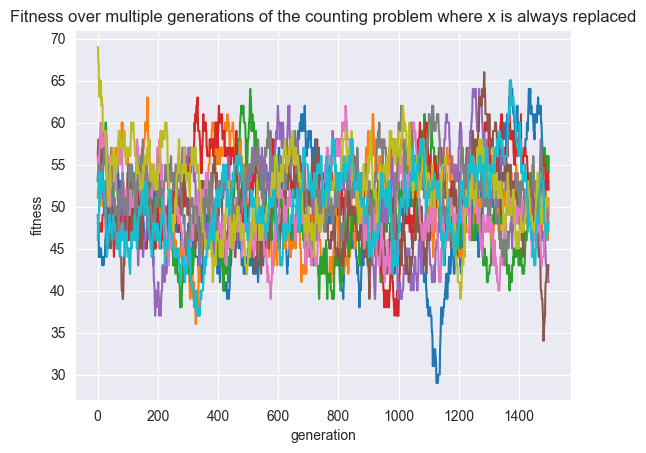

In [3]:
for i in range(10):
    count_array = CountingProblem(always_replace=True)
    g = np.arange(0., 1500.)
    plt.plot(g, count_array)
    plt.xlabel('generation')
    plt.ylabel('fitness')
    plt.title('Fitness over multiple generations of the counting problem where x is always replaced')
plt.show()

# Exercise 4.3

100%|██████████| 1500/1500 [02:20<00:00, 10.65it/s]


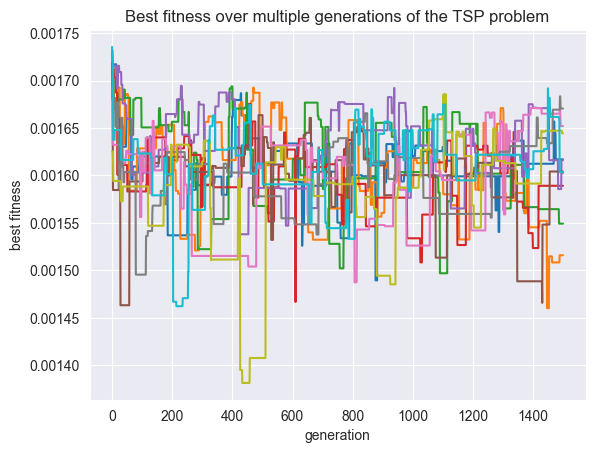

In [4]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return x, y

x_coord, y_coord = Read_Two_Column_File('file-tsp.txt')

def read_tsp_file(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for _ in range(8):
            next(data)
        for line in data:
            p = line.split()
            if p[0] == "EOF":
                break
            x.append(float(p[1]))
            y.append(float(p[2]))
    return x,y

#create candidates
def createCandidate(n_candidates=5,n_cities=10):
    candidates = []
    for i in range(n_candidates):
        candidates.append(np.random.permutation(np.arange(1,n_cities+1)))
    return candidates

#determine fitness
def determineFitness(candidates, n_cities):
    fitness_array = []
    for c in candidates:
        total_distance = 0
        for j in range(n_cities-1):
            total_distance += np.sqrt(np.square(np.absolute(x_coord[c[j]-1]-x_coord[c[j+1]-1]))+np.square(np.absolute(y_coord[c[j]-1]-y_coord[c[j+1]-1])))
        fitness_array.append(1/total_distance)
    return fitness_array

#cross-over
def crossoverPermutation(perm1, perm2, n_cities):
    perm1_new = np.zeros(n_cities)
    perm2_new = np.zeros(n_cities)
    while True:
        r = random.randint(0, n_cities) #breakpoint1
        r1 = random.randint(0, n_cities) #breakpoint2
        if r1 != r and r1 > r:
            #keep middle piece
            perm1_new[r:r1] = perm1[r:r1]
            perm2_new[r:r1] = perm2[r:r1]
            #take complement in other parent
            par1 = []
            par2 = []
            for i in range(n_cities):
                if perm1[i] not in perm1_new:
                    par1.append(perm1[i])
                if perm2[i] not in perm2_new:
                    par2.append(perm2[i])
            #fill gaps in order
            start = 0
            for j in range(len(par1)):
                if r1+j < len(perm1_new):
                    perm1_new[r1+j] = par2[j]
                    perm2_new[r1+j] = par1[j]
                else:
                    perm1_new[start] = par2[j]
                    perm2_new[start] = par1[j]
                    start += 1
            break
    return np.asarray(perm1_new, dtype = 'int'), np.asarray(perm2_new, dtype = 'int')

#mutation
def mutatedPermutation(perm, n_cities):
    while True:
        r = random.randint(0, n_cities-1)
        r1 = random.randint(0, n_cities-1)
        if r1 != r:
            temp = perm[r]
            perm[r] = perm[r1]
            perm[r1] = temp
            break
    return np.asarray(perm, dtype = 'int')

def mutate(c, n_cities, mutation_rate):
    if random.random() < mutation_rate:
        c = mutatedPermutation(c, n_cities)
    return c

def simpleTSP(generations=1500,n_cities=50,mutation_rate=0.01,crossover_rate=0.1):
    best_fitness = []
    candidates = createCandidate(n_candidates=500,n_cities=50)
    fitness_array = determineFitness(candidates, n_cities)

    for _ in tqdm(range(generations)):
        new_population = []
        best_fitness.append(min(fitness_array))
        for i in range(0,len(candidates),2):
            c1 = candidates[i]
            c2 = candidates[i+1]

             # mutate with probability mutation_rate
            c1_m = mutate(c1, n_cities, mutation_rate)
            c2_m = mutate(c2, n_cities, mutation_rate)

            # perform crossover
            if random.random() < crossover_rate:
                c1_cross, c2_cross = crossoverPermutation(c1_m, c2_m, n_cities)
                fitness_c_cross1 = determineFitness([c1_cross], n_cities)
                # append if fitter
                if fitness_c_cross1 < fitness_array[i]:
                    c1_m = c1_cross
                fitness_c_cross2 = determineFitness([c2_cross], n_cities)
                # append if fitter
                if fitness_c_cross2 < fitness_array[i+1]:
                    c1_m = c2_cross
            new_population.append(c1_m)
            new_population.append(c2_m)

        candidates = new_population
        fitness_array = determineFitness(candidates, n_cities)
    return best_fitness

for i in range(10):
    best_fitness_array = simpleTSP(generations=1500,n_cities=50)
    g = np.arange(0., 1500.)
    plt.plot(g, best_fitness_array )
    plt.xlabel('generation')
    plt.ylabel('best fitness')
    plt.title('Best fitness over multiple generations of the TSP problem')
plt.show()


100%|██████████| 1500/1500 [02:20<00:00, 10.71it/s]


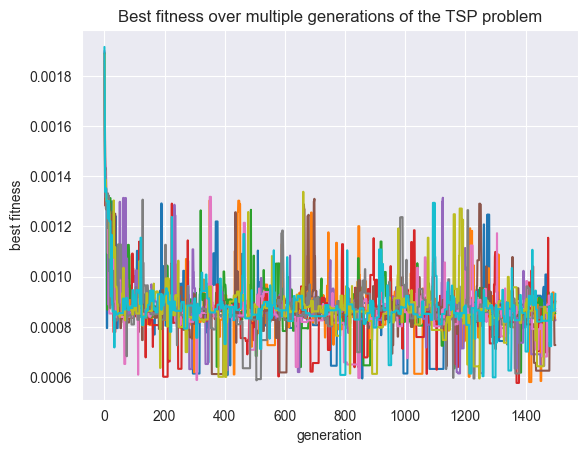

In [5]:
#simple with different dataset
x_coord, y_coord = read_tsp_file('gr431.tsp')
for i in range(10):
    best_fitness_array = simpleTSP(generations=1500,n_cities=50)
    g = np.arange(0., 1500.)
    plt.plot(g, best_fitness_array )
    plt.xlabel('generation')
    plt.ylabel('best fitness')
    plt.title('Best fitness over multiple generations of the TSP problem')
plt.show()

100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


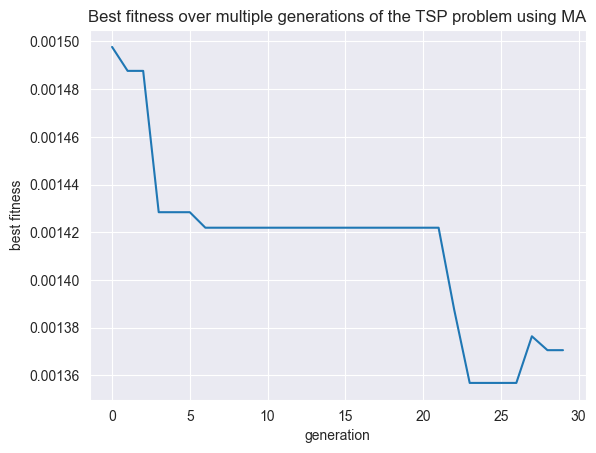

In [6]:
#Mementic 
#Apply local search to each individual
#Evaluate fitness of each candidate
#Repeat until stop condition satisfied:
#1. Select parents for reproduction
#2. Recombine and mutate
#3. Apply local search to each individual
#4. Evaluate fitness of each candidate
#5. Select next generation

x_coord, y_coord = Read_Two_Column_File('file-tsp.txt')

def twoOptSwap(perm,v1,v2,n_cities):
    perm1_new = np.zeros(n_cities)
    perm1_new[0:v1] = perm[0:v1]
    perm1_new[v1:v2] = perm[v1:v2][::-1]
    perm1_new[v2:n_cities] = perm[v2:n_cities] 
    return np.asarray(perm1_new, dtype = 'int')

def localSearch(perm,n_cities):
    best_fitness = determineFitness([perm], n_cities)
    improvement = 1
    while improvement > 0:
        improvement = 0
        for i in range(1,n_cities-1):
            for j in range(i+1,n_cities):
                if j-i == 1:
                    continue
                perm1_new = perm.copy()
                perm1_new = twoOptSwap(perm,i,j,n_cities)
                new_fitness = determineFitness([perm1_new], n_cities)
                if (new_fitness < best_fitness):
                    perm = perm1_new
                    best_fitness = new_fitness
                    improvement += 1
                else:
                    break
    return np.asarray(perm, dtype = 'int')

def memeticTSP(generations=1500,n_cities=50,mutation_rate=0.01,crossover_rate=0.1):
    best_fitness = []
    candidates = createCandidate(n_candidates=500,n_cities=50)
    #perform local search on each candidate
    for i in range(n_cities):
        candidates[i] = localSearch(candidates[i],n_cities)

    fitness_array = determineFitness(candidates, n_cities)

    for _ in tqdm(range(generations)):
        new_population = []
        best_fitness.append(min(fitness_array))
        for i in range(0,len(candidates),2):
            c1 = candidates[i]
            c2 = candidates[i+1]

             # mutate with probability mutation_rate
            c1_m = mutate(c1, n_cities, mutation_rate)
            c2_m = mutate(c2, n_cities, mutation_rate)

            # perform crossover
            if random.random() < crossover_rate:
                c1_cross, c2_cross = crossoverPermutation(c1_m, c2_m, n_cities)
                #perform local search on each candidate
                c1_cross = localSearch(c1_cross,n_cities)
                c2_cross = localSearch(c2_cross,n_cities)
                fitness_c_cross1 = determineFitness([c1_cross], n_cities)
                # append if fitter
                if fitness_c_cross1 < fitness_array[i]:
                    c1_m = c1_cross
                fitness_c_cross2 = determineFitness([c2_cross], n_cities)
                # append if fitter
                if fitness_c_cross2 < fitness_array[i+1]:
                    c1_m = c2_cross
            new_population.append(c1_m)
            new_population.append(c2_m)

        candidates = new_population
        fitness_array = determineFitness(candidates, n_cities)
    return best_fitness

#x_coord, y_coord = read_tsp_file('gr431.tsp')
for i in range(1):
    best_fitness_array = memeticTSP(generations=30,n_cities=50)
    g = np.arange(0., 30.)
    plt.plot(g, best_fitness_array )
    plt.xlabel('generation')
    plt.ylabel('best fitness')
    plt.title('Best fitness over multiple generations of the TSP problem using MA')
plt.show()

100%|██████████| 1500/1500 [39:27<00:00,  1.58s/it]


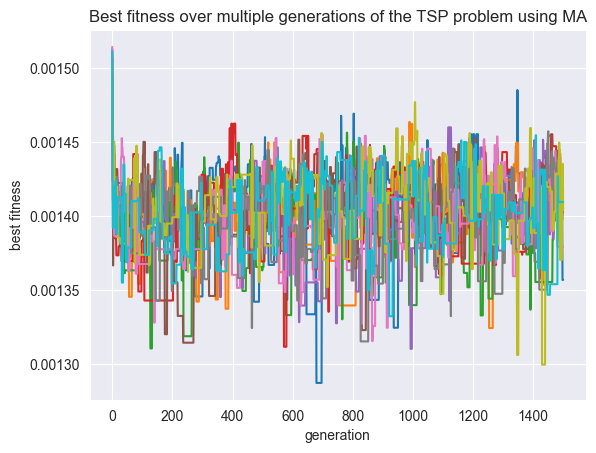

In [7]:
#x_coord, y_coord = read_tsp_file('gr431.tsp')
for i in range(10):
    best_fitness_array = memeticTSP(generations=1500,n_cities=50)
    g = np.arange(0., 1500.)
    plt.plot(g, best_fitness_array )
    plt.xlabel('generation')
    plt.ylabel('best fitness')
    plt.title('Best fitness over multiple generations of the TSP problem using MA')
plt.show()

# Exercise 4.4

In [ ]:
alphabet = list("abcdefghijklmnopqrstuvwxyz ")
target_string = "lets test some stuff"

def generate_population(target, n, alphabet):

    population = []
    for _ in range(n):
        population.append(''.join(random.choice(alphabet) for _ in range(len(target))))
    return population

def get_fitness(target, input_str):
    return sum(tar_char == input_char for tar_char, input_char in zip(target, input_str))

def mutate_string(string, probability, alphabet):
    retr_str = ""
    for char in string:
        if random.random() < probability:
            retr_str += random.choice(alphabet)
        else:
            retr_str += char
    return retr_str

def get_parents(population, K, fitness_dict):
    # select K random candidates for parent 1
    parent1_candidate = random.choices(population, k = K)
    # get the fitnesses of those candidates
    parent1_dict = dict((key, fitness_dict[key]) for key in parent1_candidate if key in fitness_dict)
    # repeat for parent 2
    parent2_candidate = random.choices(population, k = K)
    parent2_dict = dict((key, fitness_dict[key]) for key in parent2_candidate if key in fitness_dict)
    # select the candidate with maximal fitness as parent
    parent1 = max(parent1_dict, key=lambda x: parent1_dict[x])
    parent2 = max(parent2_dict, key=lambda x: parent2_dict[x])
    return parent1, parent2

def genetic_algorithm(alphabet, target_string, N, K, mu, output=True, g_max = 1000):

    optimal_fitness = len(target_string)
    population = generate_population(target_string, N, alphabet)
    number_gen = 1
    while g_max > number_gen:
        new_population = []
        fitness_dict = {}
        for string in population:
            fitness_dict[string] = get_fitness(target_string, string)
        if optimal_fitness in fitness_dict.values():
            if output:
                print(sorted(fitness_dict, key=lambda x: fitness_dict[x])[-1])
            break
        while len(new_population) < N:
            cutpoint = random.randint(0, optimal_fitness)
            parent1, parent2 = get_parents(population, K, fitness_dict)
            child = parent1[:cutpoint]+parent2[cutpoint:]
            child2 = parent2[:cutpoint]+parent1[cutpoint:]
            # Mutate
            child = mutate_string(child, mu, alphabet)
            child2 = mutate_string(child2, mu, alphabet)
            new_population.append(child)
            new_population.append(child2)
        if output:
            print(sorted(fitness_dict, key=lambda x: fitness_dict[x])[-1])
        population = new_population
        number_gen += 1
    return number_gen

In [ ]:
def plot_ga_hist(data, mu):
    sns.displot(data, kde=True)
    plt.axvline(np.mean(data), color='r')
    plt.title(f'Histogram of time to finish, mu={mu}')
    plt.xlabel("Time in generations")
    plt.gca().legend(("kde of time", "avg time"),loc="upper left")
    plt.show()

## Question 1

In [ ]:
times = []
for i in range(20):
    times.append(genetic_algorithm(alphabet, target_string, N=1000, K=2, mu=0.01, output=False))
print("-"*50)
print(f"Avg time:{np.mean(times)}")

In [ ]:
plot_ga_hist(times, 0.001)

## Question 2

In [ ]:
times = []
for i in range(20):
    times.append(genetic_algorithm(alphabet, target_string, N=1000, K=2, mu=0, output=False))
print("-"*50)
print(f"Avg time:{np.mean(times)}")
plot_ga_hist(times,0)

## Question 3

In [ ]:
times = []
for i in range(20):
    times.append(genetic_algorithm(alphabet, target_string, N=1000, K=2, mu=0.1, output=False))
print("-"*50)
print(f"Avg time:{np.mean(times)}")
plot_ga_hist(times,0.1)

## Question 4

In [ ]:
time_means, time_stds = [],[]
mus = np.arange(0,0.2,0.01)
for mu in mus:
    times = []
    for i in range(20):
        times.append(genetic_algorithm(alphabet, target_string, N=1000, K=2, mu=mu, output=False))
    time_means.append(np.mean(times))
    time_stds.append(np.std(times))

In [ ]:
means = np.array(time_means)
stds = np.array(time_stds)
ax = sns.lineplot(x=mus, y=time_means, errorbar=None)
ax.fill_between(mus, means-stds, means+stds, alpha=0.2)
plt.xlabel("µ")
plt.ylabel("generations")
plt.title("µ against generations, with 1 std confidence band")
plt.savefig("4.4_q4.png")

## Question 5

In [ ]:
time_means, time_stds = [], []
mus = np.arange(0, 0.2, 0.01)
for mu in mus:
    times = []
    for i in range(20):
        times.append(genetic_algorithm(alphabet, target_string, N=1000, K=5, mu=mu, output=False))
    time_means.append(np.mean(times))
    time_stds.append(np.std(times))


In [ ]:
means = np.array(time_means)
stds = np.array(time_stds)
ax = sns.lineplot(x=mus, y=time_means, errorbar=None)
ax.fill_between(mus, means - stds, means + stds, alpha=0.2)
plt.xlabel("µ")
plt.ylabel("generations")
plt.title("µ against generations, with K = 5 and 1 std confidence band")
plt.savefig("4.4_q5.png")